In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import itertools
import os
import string
from keras.models import Sequential
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent, LSTM, Dropout, Input
from keras.callbacks import Callback

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**HyperParameter**

In [8]:
MAXLEN = 32
MINLEN = 3
NGRAM = 5
INVERT = True #bidirectional 
BATCH_SIZE = 128
VALIDATION_SIZE = 100000

**Preprocessing Data**

In [ ]:
data_path = "/content/drive/MyDrive/NLP_Task/CorrectSpellingTask/train_tieng_viet.txt"

with open(data_path) as f:
    train = f.readlines()

In [ ]:
sentences = []
for i in range(len(train)):
    [idx, sen] = train[i].split('\t')
    sen = sen[:-1]
    sentences.append(sen)

In [ ]:
def normalizeString(s):
    # Tách dấu câu nếu kí tự liền nhau
    marks = '[.!?,-${}()]'
    r = "(["+"\\".join(marks)+"])"
    s = re.sub(r, r" \1 ", s)
    # Thay thế nhiều spaces bằng 1 space.
    s = re.sub(r"\s+", r" ", s).strip()
    return s
sentences = [normalizeString(sen).lower() for sen in sentences[:100000]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Possible nested set at position 2
  """


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89e3d02b90>]],
      dtype=object)

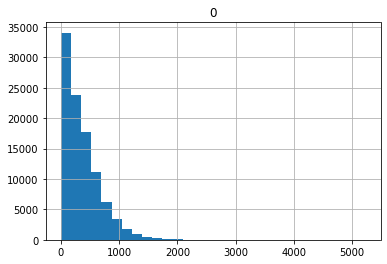

In [ ]:
pd.DataFrame([len(t) for t in sentences]).hist(bins=30)

**Generate N-grams**

In [6]:
def gen_ngrams(words, n=3):
    """ gen n-grams from given phrase or list of words """
    if isinstance(words, str):
        words = re.split('\s+', words.strip())
    
    if len(words) < n:
        padded_words = words + ['\x00'] * (n - len(words))
        yield tuple(padded_words)
    else:
        for i in range(len(words) - n + 1):
            yield tuple(words[i: i+n])

In [ ]:
ngrams = itertools.chain.from_iterable(gen_ngrams(p, NGRAM) for p in sentences)
ngrams = list(set(' '.join(t) for t in set(ngrams)))
[print(t) for t in ngrams[:5]]
print('Number of {}-gram: {}'.format(NGRAM, len(ngrams)))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89996ff0d0>]],
      dtype=object)

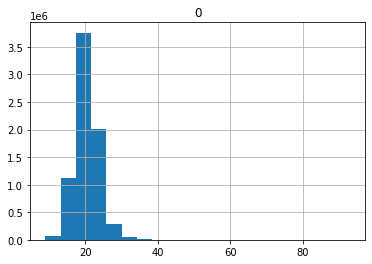

In [ ]:
pd.DataFrame([len(ngram) for ngram in ngrams]).hist(bins=20)

**Helper Function**

In [11]:
accented_chars = {
    'a': u'a á à ả ã ạ â ấ ầ ẩ ẫ ậ ă ắ ằ ẳ ẵ ặ',
    'o': u'o ó ò ỏ õ ọ ô ố ồ ổ ỗ ộ ơ ớ ờ ở ỡ ợ',
    'e': u'e é è ẻ ẽ ẹ ê ế ề ể ễ ệ',
    'u': u'u ú ù ủ ũ ụ ư ứ ừ ử ữ ự',
    'i': u'i í ì ỉ ĩ ị',
    'y': u'y ý ỳ ỷ ỹ ỵ',
    'd': u'd đ',
}

plain_char_map = {}
for c, variants in accented_chars.items():
    for v in variants.split(' '):
        plain_char_map[v] = c


def remove_accent(text):
    return u''.join(plain_char_map.get(char, char) for char in text)

In [47]:
class CharacterCodec(object):
    def __init__(self, alphabet, maxlen):
        self.alphabet = list(sorted(set(alphabet)))
        self.index_alphabet = dict((c, i) for i, c in enumerate(self.alphabet))
        self.maxlen = maxlen

    def encode(self, C, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        X = np.zeros((maxlen, len(self.alphabet)))
        for i, c in enumerate(C[:maxlen]):
            X[i, self.index_alphabet[c]] = 1
        return X
    
    def try_encode(self, C, maxlen=None):
        try:
            return self.encode(C, maxlen)
        except KeyError:
            return None

    def decode(self, X, calc_argmax=True):
        if calc_argmax:
            X = X.argmax(axis=-1)
        return ''.join(self.alphabet[x] for x in X)


#\x00 is the padding characters
alphabet = set('\x00 _' + string.ascii_lowercase + string.digits + ''.join(plain_char_map.keys()))
codec = CharacterCodec(alphabet, MAXLEN)

**Generate data**

In [ ]:
np.random.shuffle(ngrams)
train_size = len(ngrams) - VALIDATION_SIZE
train_set = ngrams[:train_size]
validation_set = ngrams[train_size:]

def gen_batch(it, size):
    """ batch the input iterator to iterator of list of given size"""
    for _, group in itertools.groupby(enumerate(it), lambda x: x[0] // size):
        yield list(zip(*group))[1]


def gen_stream(ngrams):
    """ generate an infinite stream of (input, output) pair from phrases """
    while True:
        for s in ngrams:
            output_s = s + '\x00' * (MAXLEN - len(s))
            input_s = remove_accent(output_s)    
            input_s = input_s[::-1] if INVERT else input_s
            input_vec = codec.try_encode(input_s)
            output_vec = codec.try_encode(output_s)
            if input_vec is not None and output_vec is not None:
                yield input_vec, output_vec


def gen_data(ngrams, batch_size=128):
    """ generate infinite X, Y array of batch_size from given phrases """
    for batch in gen_batch(gen_stream(ngrams), size=batch_size):
        # we need to return X, Y array from one batch, which is a list of (x, y) pair
        X, Y = zip(*batch)
        yield np.array(X), np.array(Y)

**Training**

In [ ]:
HIDDEN_SIZE = 256

model_LSTM = Sequential([
    LSTM(256, return_sequences=True,input_shape = (MAXLEN,len(alphabet))),
    tf.keras.layers.Dropout(0.2),
    LSTM(256, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    TimeDistributed(Dense(len(alphabet))),
    Activation('softmax')
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=50,
                                                      mode='min',
                                                      restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM', monitor='val_loss', save_best_only=True, save_feq='epoch')
model_LSTM.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 256)           371712    
                                                                 
 dropout (Dropout)           (None, 32, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 32, 256)           0         
                                                                 
 time_distributed (TimeDistr  (None, 32, 106)          27242     
 ibuted)                                                         
                                                                 
 activation (Activation)     (None, 32, 106)           0         
                                                        

In [ ]:
train_generator = gen_data(train_set, batch_size=BATCH_SIZE)
validation_generator = gen_data(validation_set, batch_size=BATCH_SIZE)

history = model_LSTM.fit(train_generator,epochs=30,steps_per_epoch=20000,
                    validation_data=validation_generator,validation_steps=20000,verbose=1,
                    callbacks=[early_stopping,model_checkpoint])

Epoch 1/30
19998/20000 [============================>.] - ETA: 0s - loss: 1.7141 - accuracy: 0.5855

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 675s 33ms/step - loss: 1.7141 - accuracy: 0.5855 - val_loss: 1.6084 - val_accuracy: 0.6084
Epoch 2/30
19999/20000 [============================>.] - ETA: 0s - loss: 1.6116 - accuracy: 0.6081

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 643s 32ms/step - loss: 1.6116 - accuracy: 0.6081 - val_loss: 1.5952 - val_accuracy: 0.6119
Epoch 3/30
19998/20000 [============================>.] - ETA: 0s - loss: 1.6017 - accuracy: 0.6105

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 636s 32ms/step - loss: 1.6017 - accuracy: 0.6105 - val_loss: 1.5901 - val_accuracy: 0.6129
Epoch 4/30
20000/20000 [==============================] - ETA: 0s - loss: 1.5967 - accuracy: 0.6119

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 636s 32ms/step - loss: 1.5967 - accuracy: 0.6119 - val_loss: 1.5858 - val_accuracy: 0.6141
Epoch 5/30
19998/20000 [============================>.] - ETA: 0s - loss: 1.5932 - accuracy: 0.6128

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 636s 32ms/step - loss: 1.5932 - accuracy: 0.6128 - val_loss: 1.5834 - val_accuracy: 0.6148
Epoch 6/30
20000/20000 [==============================] - ETA: 0s - loss: 1.5909 - accuracy: 0.6134

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 642s 32ms/step - loss: 1.5909 - accuracy: 0.6134 - val_loss: 1.5817 - val_accuracy: 0.6153
Epoch 7/30
20000/20000 [==============================] - ETA: 0s - loss: 1.5890 - accuracy: 0.6139

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 659s 33ms/step - loss: 1.5890 - accuracy: 0.6139 - val_loss: 1.5801 - val_accuracy: 0.6157
Epoch 8/30
19999/20000 [============================>.] - ETA: 0s - loss: 1.5876 - accuracy: 0.6143

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 636s 32ms/step - loss: 1.5876 - accuracy: 0.6143 - val_loss: 1.5787 - val_accuracy: 0.6160
Epoch 9/30
19998/20000 [============================>.] - ETA: 0s - loss: 1.5865 - accuracy: 0.6145

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 636s 32ms/step - loss: 1.5865 - accuracy: 0.6145 - val_loss: 1.5784 - val_accuracy: 0.6161
Epoch 10/30
19999/20000 [============================>.] - ETA: 0s - loss: 1.5856 - accuracy: 0.6148

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 636s 32ms/step - loss: 1.5856 - accuracy: 0.6148 - val_loss: 1.5778 - val_accuracy: 0.6163
Epoch 11/30
19998/20000 [============================>.] - ETA: 0s - loss: 1.5849 - accuracy: 0.6150

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 637s 32ms/step - loss: 1.5849 - accuracy: 0.6150 - val_loss: 1.5768 - val_accuracy: 0.6165
Epoch 12/30
20000/20000 [==============================] - ETA: 0s - loss: 1.5842 - accuracy: 0.6151

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 645s 32ms/step - loss: 1.5842 - accuracy: 0.6151 - val_loss: 1.5761 - val_accuracy: 0.6166
Epoch 13/30
19999/20000 [============================>.] - ETA: 0s - loss: 1.5834 - accuracy: 0.6153

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 640s 32ms/step - loss: 1.5834 - accuracy: 0.6153 - val_loss: 1.5755 - val_accuracy: 0.6168
Epoch 14/30
19999/20000 [============================>.] - ETA: 0s - loss: 1.5830 - accuracy: 0.6154

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 640s 32ms/step - loss: 1.5830 - accuracy: 0.6154 - val_loss: 1.5750 - val_accuracy: 0.6170
Epoch 15/30
19999/20000 [============================>.] - ETA: 0s - loss: 1.5825 - accuracy: 0.6156

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 643s 32ms/step - loss: 1.5825 - accuracy: 0.6156 - val_loss: 1.5745 - val_accuracy: 0.6170
Epoch 16/30
19998/20000 [============================>.] - ETA: 0s - loss: 1.5821 - accuracy: 0.6157

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 648s 32ms/step - loss: 1.5821 - accuracy: 0.6157 - val_loss: 1.5742 - val_accuracy: 0.6172
Epoch 17/30
19999/20000 [============================>.] - ETA: 0s - loss: 1.5817 - accuracy: 0.6158

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM/assets


20000/20000 [==============================] - 648s 32ms/step - loss: 1.5817 - accuracy: 0.6158 - val_loss: 1.5741 - val_accuracy: 0.6171
Epoch 18/30
 3971/20000 [====>.........................] - ETA: 4:55 - loss: 1.5814 - accuracy: 0.6158

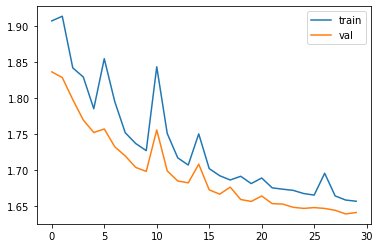

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

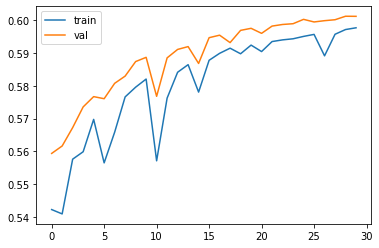

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()

In [3]:
model_LSTM = tf.keras.models.load_model('/content/drive/MyDrive/NLP_Task/CorrectSpellingTask/LSTM')

In [58]:
from collections import Counter


from collections import Counter


def guess(ngram):
    text = ' '.join(ngram)
    text += '\x00' * (MAXLEN - len(text))
    if INVERT:
        text = text[::-1]
    preds = model_LSTM.predict(np.array([codec.encode(text)]), verbose=0)
    classes_x = np.argmax(preds,axis=1)
    
    return codec.decode(classes_x[0], calc_argmax=False).strip('\x00')


def add_accent(text):
    ngrams = list(gen_ngrams(text.lower(), n=NGRAM))
    guessed_ngrams = list(guess(ngram) for ngram in ngrams)
    
    candidates = [Counter() for _ in range(len(guessed_ngrams) + NGRAM - 1)]
    print(len(candidates))
    for nid, ngram in enumerate(guessed_ngrams):
        for wid, word in enumerate(re.split(' +', ngram)):
            if nid + wid >= len(candidates):
               break
            candidates[nid + wid].update([word])
    output = ' '.join(c.most_common(1)[0][0] for c in candidates)
    return output

print(u'"{}"'.format(add_accent('co khi nao roi xa')))

5
"e1   bbbaaa 4d     2 0  c 10  c  0c c01"
